<a href="https://colab.research.google.com/github/takao8/MLTSAProject/blob/master/NEPOOL_Analaysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [229]:
import numpy as np
import pandas as pd
import pylab as plt

from tabulate import tabulate
import pickle
from urllib.request import urlopen
import warnings

warnings.filterwarnings('ignore')

from sklearn.decomposition import PCA
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

!pip install fbprophet

import fbprophet
from fbprophet import Prophet
from fbprophet import diagnostics
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

# Load data

Load the previously scraped datasets from the GitHub repository.

In [0]:
nepool = pd.read_excel('https://github.com/takao8/MLTSAProject/blob/master/data/PJM_NEPOOL_hourly_data_Jan2000_Jul2019.xlsx?raw=true')
weather_noaa = pd.read_csv('https://github.com/takao8/MLTSAProject/raw/master/data/boston_weather_cleaned.csv', index_col='DATE')

nepool['Date'] = pd.to_datetime(nepool['Date']).dt.round('H')
nepool.set_index("Date", inplace=True)
weather_noaa.index = pd.to_datetime(weather_noaa.index)

# Gaussian Processing

The NOAA data has a lot of missing values for some of the features. We will use gaussian processing to interploate the missing values.

In [162]:
# Find out what percent of values are nan for each feature
table = []
for c in weather_noaa.columns:
    table.append([c, round((1 - len(weather_noaa[c].dropna()) / len(weather_noaa[c]))*100, 1)])

print(tabulate(table, headers=['Feature', '% nan values']))

Feature                      % nan values
-------------------------  --------------
HourlyAltimeterSetting               26.9
HourlyDewPointTemperature            13.6
HourlyDryBulbTemperature             13.6
HourlyPrecipitation                   0
HourlyRelativeHumidity               13.6
HourlySeaLevelPressure               25.3
HourlyWetBulbTemperature             28.5
HourlyWindSpeed                      13.6


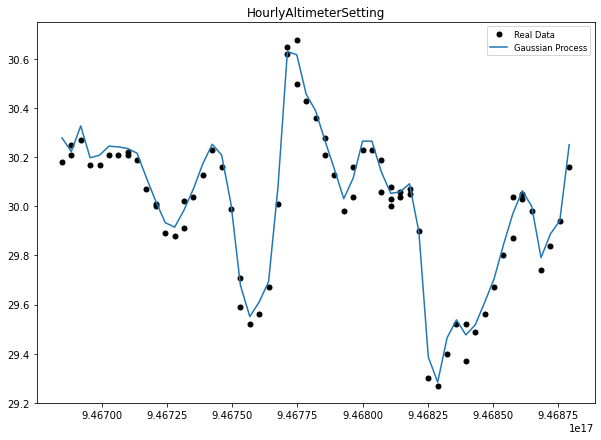

In [163]:
# Note that all nan precipitation values are zero
weather_noaa['HourlyPrecipitation'].fillna(0, inplace = True)

step, i, col = 72, 0, 0

# Get features and standardize them
feat = weather_noaa.drop(columns=['HourlyPrecipitation']).dropna().values[step*i : step*(i+1)]
feat_st = (feat - feat.mean()) / feat.std()

hour = weather_noaa.index.values.astype(float)[step*i : step*(i+1)]
hour_st = np.array((hour - hour.mean()) / hour.std())

# Run the gaussian process regression
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=100, alpha=0.015)
gpr.fit(hour_st.reshape(-1, 1), feat_st)

# Predict the missing values
feat_pr = gpr.predict(hour_st.reshape(-1, 1)) * feat.std() + feat.mean()

plt.figure(figsize=(10, 7))
plt.plot(hour, feat[step*i : step*(i+1), col], 'k.', markersize=10, label='Real Data')
plt.plot(hour, feat_pr[step*i : step*(i+1), col], label='Gaussian Process')
plt.title(weather_noaa.drop(columns=['HourlyPrecipitation']).columns[col])
plt.legend(fontsize='small')

plt.show();

# PCA

First, we will perform PCA on the weather dataset to reduce the feature space to fewer variables.

In [164]:
# Get features and standardize them
feat = weather_noaa.dropna().values
feat_st = (feat - feat.mean()) / feat.std()

# Perform the PCA
pca = PCA(random_state=667).fit(feat_st)

# See how much of the variance is explained by the first n components
for i in range(pca.n_components_):
    exp_var = sum(pca.explained_variance_ratio_[:i+1])
    print('The first {0} components explain {1:.2%} of the variance in the data'.format(i+1, exp_var))

The first 1 components explain 70.88% of the variance in the data
The first 2 components explain 97.65% of the variance in the data
The first 3 components explain 99.70% of the variance in the data
The first 4 components explain 99.94% of the variance in the data
The first 5 components explain 99.99% of the variance in the data
The first 6 components explain 100.00% of the variance in the data
The first 7 components explain 100.00% of the variance in the data
The first 8 components explain 100.00% of the variance in the data


In [165]:
weights = pd.DataFrame(pca.components_, columns=weather_noaa.columns, index =['PC' + str(n+1) for n in range(pca.n_components_)])
weights.columns = [col[6:] for col in weights.columns]
weights.head()

,AltimeterSetting,DewPointTemperature,DryBulbTemperature,Precipitation,RelativeHumidity,SeaLevelPressure,WetBulbTemperature,WindSpeed
PC1,0.001651,-0.608183,-0.520854,-0.000077,-0.306564,0.001640,-0.513472,0.034407
PC2,0.001097,-0.023590,0.385946,-0.000488,-0.903801,0.001090,0.178793,0.040775
PC3,-0.016114,0.027513,0.006924,0.000814,0.047053,-0.016097,-0.000917,0.998229
PC4,0.013344,0.782691,-0.487737,-0.002347,-0.281237,0.013236,-0.264635,-0.004745
PC5,-0.030074,0.127040,0.583616,0.003374,0.087763,-0.029850,-0.795968,-0.013387


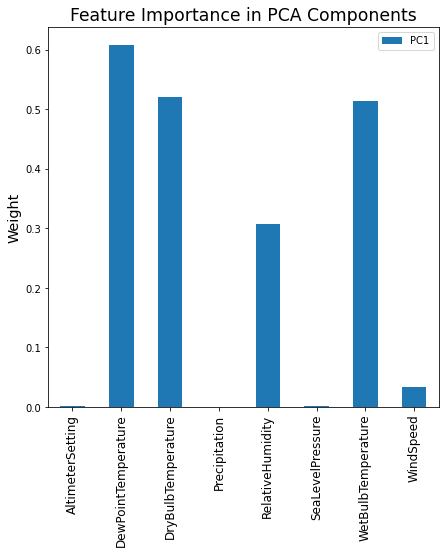

In [166]:
fig, ax = plt.subplots(figsize=(7, 7))
abs(weights.iloc[0, :]).plot(kind='bar', ax=ax)
ax.set_title('Feature Importance in PCA Components', fontsize='xx-large')
ax.set_ylabel('Weight', fontsize='x-large')
ax.set_xticklabels(weights.columns, rotation=90, fontsize='large')
ax.legend(loc='best')

fig.show();

**Figure:** The figure above shows the relative importance of each feature in the first principal component of the weather data. Over 70% of the data was able to be explained by a mostly even weighting of the `Dew Point Temperature`, `Dry Bulb Temperature`, and `Wet Bulb Temperature`. The `Relative Humidity` was also an important feature in this principal component.

In [167]:
data = nepool[['Nepool_Load_Hist']].copy()

weather_noaa_clean = weather_noaa.dropna()
weather_pc = pd.DataFrame(data=pca.fit_transform(weather_noaa_clean)[:, 0],
                          index=weather_noaa_clean.index,
                          columns=['weather_pc'])

data = nepool[['Nepool_Load_Hist']].join(weather_pc).dropna().reset_index()
data = data.join(weather_noaa_clean['HourlyPrecipitation'], on='index')
data.head()

,index,Nepool_Load_Hist,weather_pc,HourlyPrecipitation
0,2000-01-01 16:00:00,12531.0,16.074515,0.0
1,2000-01-01 19:00:00,14951.0,18.329652,0.0
2,2000-01-02 01:00:00,10637.0,7.956751,0.0
3,2000-01-02 04:00:00,9731.0,9.905874,0.0
4,2000-01-02 07:00:00,10476.0,9.871434,0.0


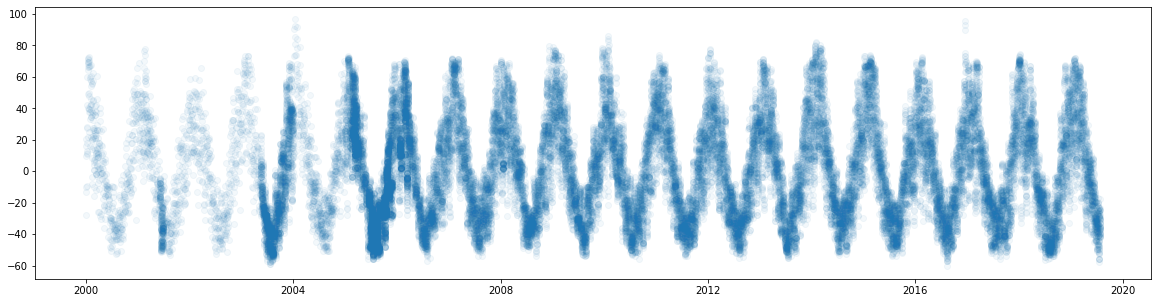

In [168]:
plt.figure(figsize=(20, 5))
plt.scatter(data['index'][::4], data.weather_pc[::4], alpha=0.05);

# Simple Prophet Model

We will use the Prophet package by Facebook to implement forecasting methods and predict furute energy loads.

## Acquire and clean data

In [0]:
if False:
    data = data.rename(columns={'index':'ds', 'Nepool_Load_Hist':'y', 'HourlyPrecipitation':'precipitation'})
    data.to_csv('data.csv')

    colx = ['y', 'weather_pc', 'precipitation']

    data_st = (data[colx] - data[colx].mean()) / data[colx].std()
    data_st['ds'] = data['ds']
    data_st.to_csv('data_st.csv')
else:
    # Load data and standardized data from GitHub
    data = pd.read_csv('https://github.com/takao8/MLTSAProject/blob/master/data/data.csv?raw=true', index_col=0)
    data.ds = pd.to_datetime(data.ds)

    data_st = pd.read_csv('https://github.com/takao8/MLTSAProject/blob/master/data/data_st.csv?raw=true', index_col=0)
    data_st.ds = pd.to_datetime(data_st.ds)

## Train the model

In [0]:
if False:
    prophet1 = Prophet()
    prophet1.fit(data_st)     # will take 7 minutes to run

    prophet1.stan_backend.logger = None
    with open("prophet1.pickle", "wb") as f:
        pickle.dump(prophet1, f)
else:
    prophet1_location = 'https://github.com/takao8/MLTSAProject/blob/master/trained_models/prophet1.pickle?raw=true'
    prophet1 = pickle.load(urlopen(prophet1_location))

## Forecast future energy load

In [232]:
n_months = 3
n_days = n_months * 30
n_hours = n_days * 24
print("We want to forecast:\n - {0} months, which is\n - {1} days, which is\n - {2} hours".format(n_months, n_days, n_hours))

# Create dataframe containing future energy load predictions
pred_period1 = prophet1.make_future_dataframe(periods=n_hours, freq="H")

if False:
    preds1 = prophet1.predict(pred_period1)  # will take 2 minutes
    preds1.to_csv('preds1.csv')
else:
    preds1 = pd.read_csv('https://github.com/takao8/MLTSAProject/blob/master/data/prophet1/preds1.csv?raw=true', index_col=0)
    preds1['ds'] = pd.to_datetime(preds1.ds)

We want to forecast:
 - 3 months, which is
 - 90 days, which is
 - 2160 hours


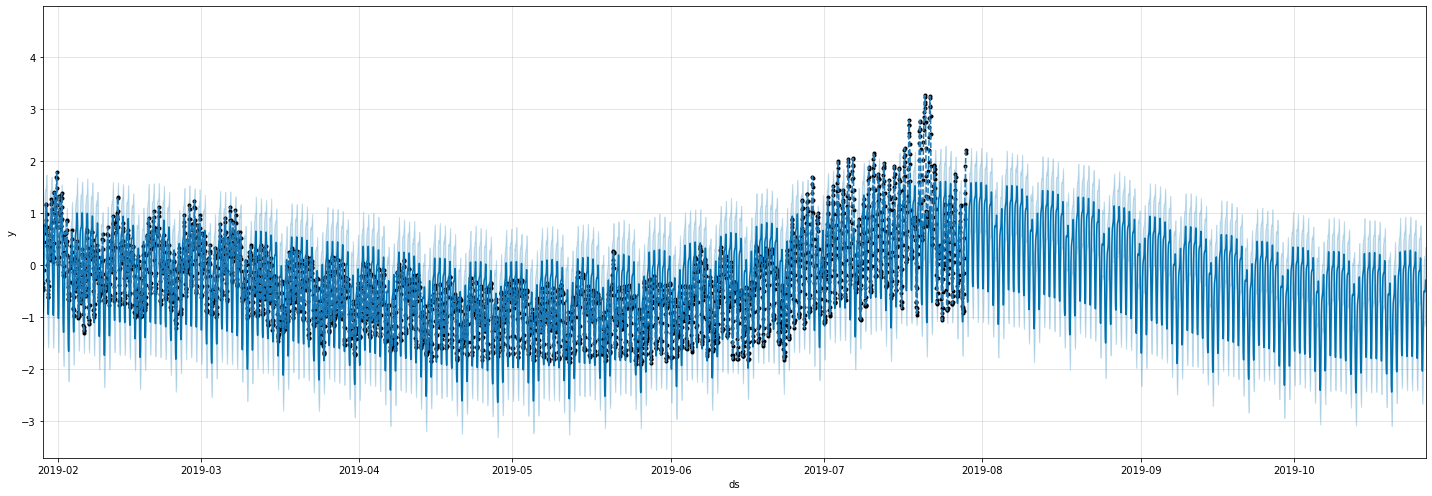

In [233]:
backtrack = n_hours * 2  # Show two 3-month periods
backtrack = int(backtrack)

fig = prophet1.plot(preds1[-backtrack - n_hours:], figsize=(20, 7))
plt.plot(data_st.ds[-backtrack:], data_st.y[-backtrack:], '--')
plt.xlim(data_st.ds.values[-backtrack], preds1.ds.values[-1] + np.timedelta64(years=1))
fig.show();

fig.savefig('prophet1_predictions.png')

## Examine the seasonality components of the model

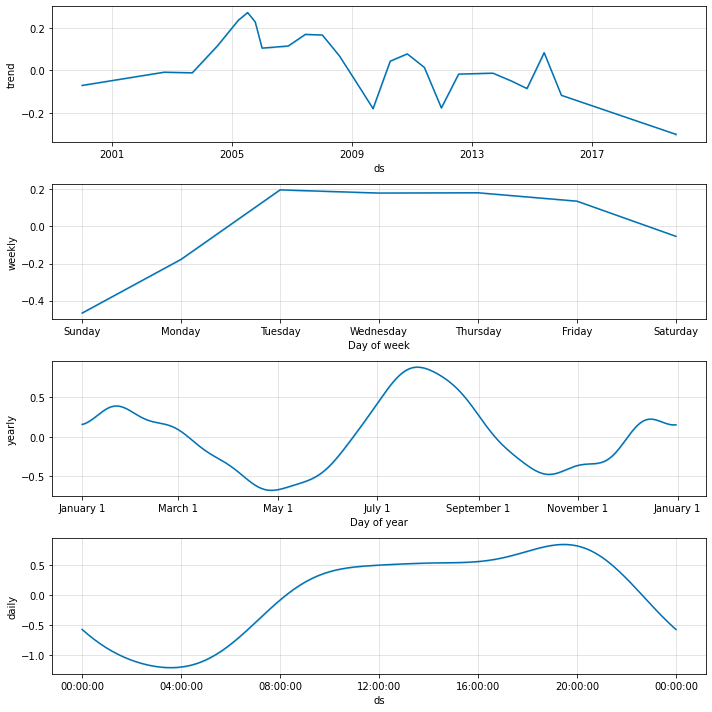

In [234]:
fig = prophet1.plot_components(preds1, figsize=(10, 10))
fig.savefig('prophet1_components.png')
fig.show();

## Model Validation

In [0]:
def mape(y_pred, y_true):
    ''' Mean average percent error statistic '''
    y_true, y_pred = np.array(y_true), np.array(y_pred) 
    return np.mean(np.abs(y_pred - y_true) / np.abs(y_true))

def unstandardize(y):
    return y * data.y.std() + data.y.mean()

In [0]:
if False:
    # Will take 37 minutes
    result1_cv = diagnostics.cross_validation(prophet1, initial="730 days", period="400 days",  horizon="90 days")
    result1_cv.to_csv('result1_cv.csv')

    # Unstandardize the results
    result1_cv_adj = result1_cv.copy()
    result1_cv_adj[['yhat', 'yhat_lower', 'yhat_upper', 'y']] *= data.y.std()
    result1_cv_adj[['yhat', 'yhat_lower', 'yhat_upper', 'y']] += data.y.mean()
    result1_cv_adj.to_csv('result1_cv_adj.csv')
else:
    result1_cv = pd.read_csv('https://github.com/takao8/MLTSAProject/blob/master/data/prophet1/result1_cv.csv?raw=true', index_col=0)
    result1_cv_adj = pd.read_csv('https://github.com/takao8/MLTSAProject/blob/master/data/prophet1/result1_cv_adj.csv?raw=true', index_col=0)
    
    result1_cv['ds'] = pd.to_datetime(result1_cv.ds)
    result1_cv_adj['ds'] = pd.to_datetime(result1_cv_adj.ds)

    result1_cv['cutoff'] = pd.to_datetime(result1_cv.cutoff)
    result1_cv_adj['cutoff'] = pd.to_datetime(result1_cv_adj.cutoff)

In [237]:
print("Mean average percent error: {:.2%}".format(mape(result1_cv_adj.yhat, result1_cv_adj.y)))

Mean average percent error: 7.78%


In [0]:
if False:
    result1_p = performance_metrics(result1_cv_adj)
    result1_p.to_csv('result1_p.csv')
else:
    result1_p = pd.read_csv('https://github.com/takao8/MLTSAProject/blob/master/data/prophet1/result1_p.csv?raw=true', index_col=0)
    result1_p['horizon'] = pd.to_timedelta(result1_p.horizon)

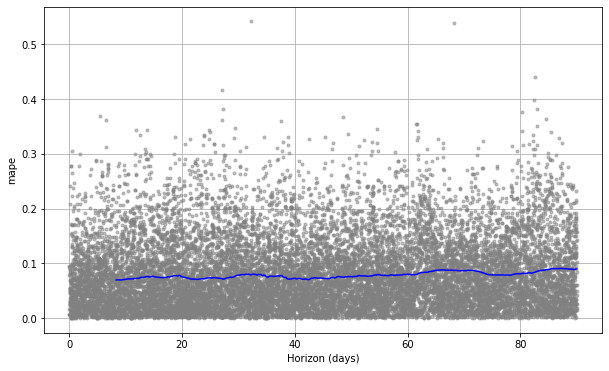

In [239]:
fig = plot_cross_validation_metric(result1_cv_adj[::2], metric='mape')
fig.savefig('prophet1_horizon_mape.png')

In [0]:
import seaborn as sns

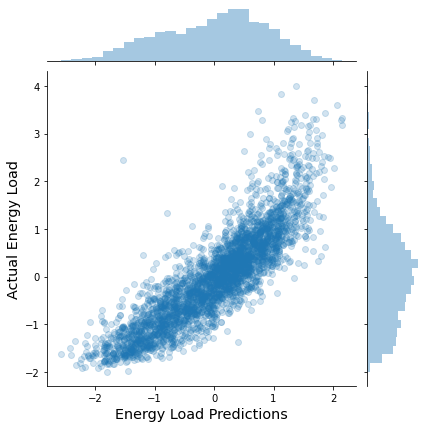

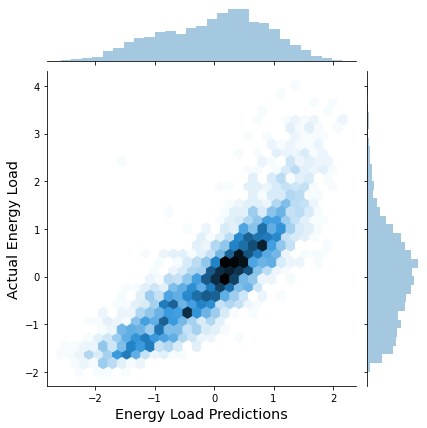

In [305]:
step = 50
grid = sn.jointplot(preds1.yhat[:-n_hours][::step], data_st.y[::step], alpha=0.2)
grid.set_axis_labels('Energy Load Predictions', 'Actual Energy Load', fontsize='x-large');
grid.savefig('joint_scatter1.png');

grid = sn.jointplot(preds1.yhat[:-n_hours][::step], data_st.y[::step], kind='hex')
grid.set_axis_labels('Energy Load Predictions', 'Actual Energy Load', fontsize='x-large');
grid.savefig('joint_hex1.png');

# More complex model

In [0]:
# Create base instance of Prophet
prophet2 = Prophet(seasonality_prior_scale=35,
                 weekly_seasonality=False,)

# Add holidays
prophet2.add_country_holidays(country_name="US")

# Add seasonalities
prophet2.add_seasonality(name='weekly', period=7, fourier_order=10)
prophet2.add_seasonality(name='quarterly', period=365/4, fourier_order=10)

# Add weather regressor
prophet2.add_regressor('weather_pc')
prophet2.add_regressor('precipitation')
prophet2

# Fit model to data
if False:
    prophet2.fit(data_st)     # will take 13 minutes to run

    prophet2.stan_backend.logger = None
    with open("prophet2.pickle", "wb") as f:
        pickle.dump(prophet2, f)
else:
    prophet2_location = 'https://github.com/takao8/MLTSAProject/blob/master/trained_models/prophet2.pickle?raw=true'
    prophet2 = pickle.load(urlopen(prophet2_location))

In [241]:
n_months = 3
n_days = n_months * 30
n_hours = n_days * 24
print("We want to forecast:\n - {0} months, which is\n - {1} days, which is\n - {2} hours".format(n_months, n_days, n_hours))

We want to forecast:
 - 3 months, which is
 - 90 days, which is
 - 2160 hours


In [0]:
def fill_regressors(ds):
    '''
    This function takes in a datetime and returns the average `weather_pc` and
    'precipitation` (standardized) value for each observation in the historical 
    dataset.

    The mean value is based on observations that occur in the same month, on the
    same day, and within +/- 2 hours of the input datetime. There are at most 5
    observations per year that fit this description.
    '''
    month = ds.month
    day = ds.day
    hour = ds.hour
    sub = data_st[(data_st.ds.dt.month == month) & (data_st.ds.dt.day == day) & (abs(data_st.ds.dt.hour - hour) < 2)]
    return sub[['weather_pc', 'precipitation']].mean()

# Forecast the weather for the prediction period based on historical data
if False:
    # Create dataframe containing each hour in the prediction period
    pred_period2 = prophet2.make_future_dataframe(periods=n_hours, freq="H")

    # Create empty columns for the `weather_pc` and `precipitation` data
    pred_period2['weather_pc'] = 0.
    pred_period2['precipitation'] = 0.

    # Fill in the historical data for the `weather_pc` and `precipitation` columns
    pred_period2['weather_pc'][:-n_hours] = data_st.weather_pc
    pred_period2['precipitation'][:-n_hours] = data_st.precipitation

    # Forecast the weather and precipitation for the prediction period
    pred_weather_regressors = pred_period2.iloc[-n_hours:].ds.apply(fill_regressors)

    # Add the forecasted data to the prediction period dataframe
    pred_period2['weather_pc'][-n_hours:] = pred_weather_regressors.weather_pc
    pred_period2['precipitation'][-n_hours:] = pred_weather_regressors.precipitation

    # Save the prediction perdiod dataframe
    pred_period2.to_csv('pred_period2.csv')
else:
    # Load the prediction period data from GitHub
    pred_period2 = pd.read_csv('https://github.com/takao8/MLTSAProject/blob/master/data/prophet2/pred_period2.csv?raw=true', index_col=0)
    pred_period2['ds'] = pd.to_datetime(pred_period2.ds)

In [0]:
if False:
    # Forecast the energy load over the prediction perdiod dataframe
    preds2 = prophet2.predict(pred_period2)  # will take 2 minutes

    # Save the predictions in two separate files big the full dataset is larger than 100MB
    half = len(preds2) // 2
    preds2[:half].to_csv('preds2_1.csv')
    preds2[half].to_csv('preds2_2.csv')
else:
    # Load the prediction data from GitHub
    preds2_1 = pd.read_csv('https://github.com/takao8/MLTSAProject/blob/master/data/prophet2/preds2_1.csv?raw=true', index_col=0)
    preds2_2 = pd.read_csv('https://github.com/takao8/MLTSAProject/blob/master/data/prophet2/preds2_2.csv?raw=true', index_col=0)
    preds2 = pd.concat([preds2_1, preds2_2])
    preds2['ds'] = pd.to_datetime(preds2.ds)

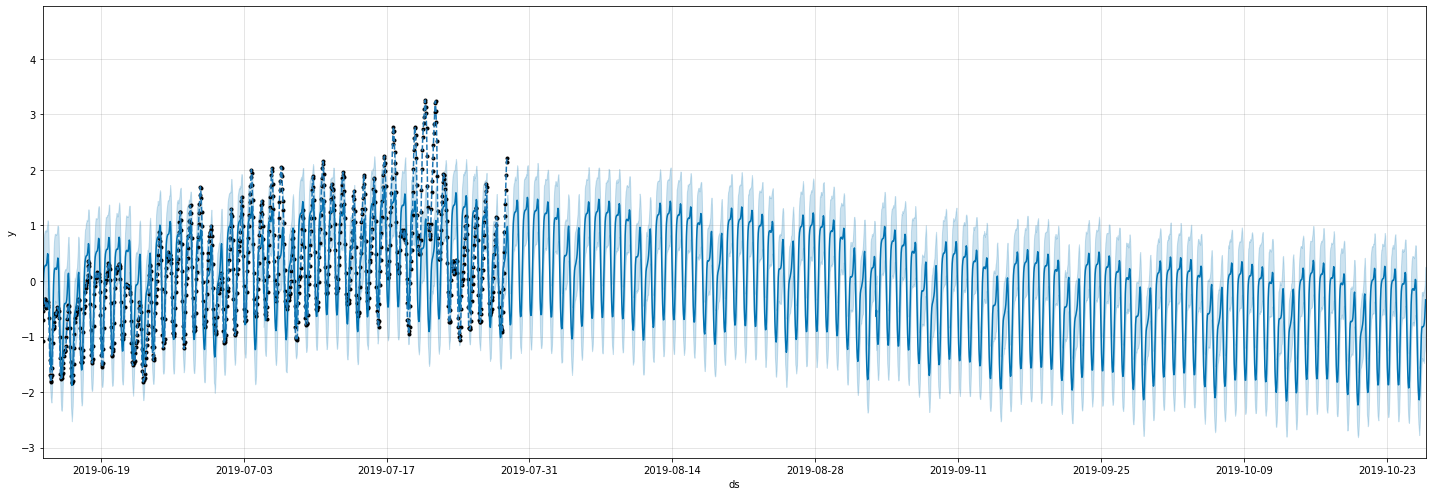

In [244]:
backtrack = n_hours * 0.5  # Show two 3-month periods
backtrack = int(backtrack)

fig = prophet2.plot(preds2[-backtrack - n_hours:], figsize=(20, 7))
plt.plot(data_st.ds[-backtrack:], data_st.y[-backtrack:], '--')
plt.xlim(data_st.ds.values[-backtrack], preds2.ds.values[-1] + np.timedelta64(years=1))
fig.show();

fig.savefig('prophet2_predictions.png')

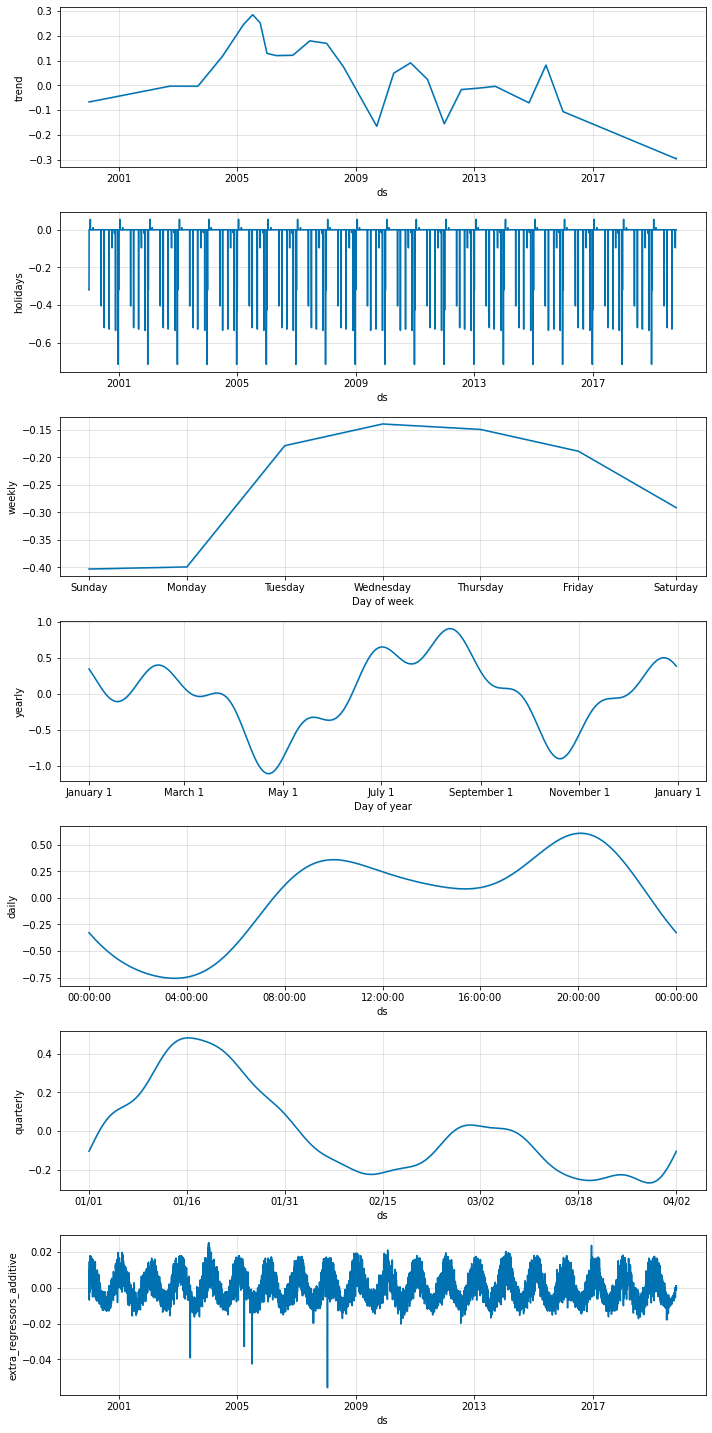

In [245]:
fig = prophet2.plot_components(preds2, figsize=(10, 20))
fig.savefig('prophet2_components.png')
fig.show();

In [0]:
if False:
    # Will take over 1 hour 45 minutes
    result2_cv = diagnostics.cross_validation(prophet2, initial="730 days", period="400 days",  horizon="90 days")
    result2_cv.to_csv('result2_cv.csv')

    # Unstandardize the results
    result2_cv_adj = result2_cv.copy()
    result2_cv_adj[['yhat', 'yhat_lower', 'yhat_upper', 'y']] *= data.y.std()
    result2_cv_adj[['yhat', 'yhat_lower', 'yhat_upper', 'y']] += data.y.mean()
    result2_cv_adj.to_csv('result2_cv_adj.csv')

else:
    # Load the cross-validation results from GitHub
    result2_cv = pd.read_csv('https://github.com/takao8/MLTSAProject/blob/master/data/prophet2/result2_cv.csv?raw=true', index_col=0)
    result2_cv_adj = pd.read_csv('https://github.com/takao8/MLTSAProject/blob/master/data/prophet2/result2_cv_adj.csv?raw=true', index_col=0)
    
    result2_cv['ds'] = pd.to_datetime(result2_cv.ds)
    result2_cv_adj['ds'] = pd.to_datetime(result2_cv_adj.ds)
    
    result2_cv['cutoff'] = pd.to_datetime(result2_cv.cutoff)
    result2_cv_adj['cutoff'] = pd.to_datetime(result2_cv_adj.cutoff)

In [247]:
print("Mean average percent error: {:.2%}".format(mape(result2_cv_adj.yhat, result2_cv_adj.y)))

Mean average percent error: 7.81%


In [0]:
if False:
    # Calculate the performance metrics on the cross-validation results
    result2_p = performance_metrics(result2_cv_adj)
    result2_p.to_csv('result2_p.csv')
else:
    # Load the performance metrics from GitHub
    result2_p = pd.read_csv('https://github.com/takao8/MLTSAProject/blob/master/data/prophet2/result2_p.csv?raw=true', index_col=0)
    result2_p['horizon'] = pd.to_timedelta(result2_p.horizon)

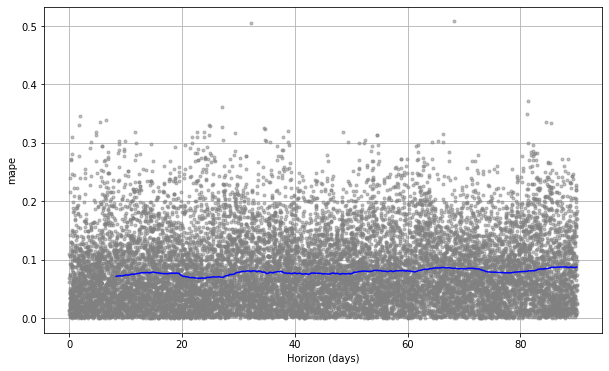

In [249]:
fig = plot_cross_validation_metric(result2_cv_adj[::2], metric='mape')
fig.savefig('prophet2_horizon_mape.png')

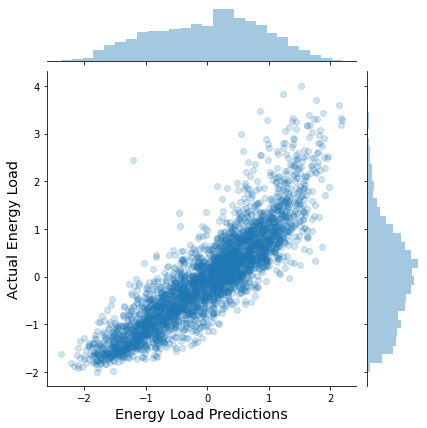

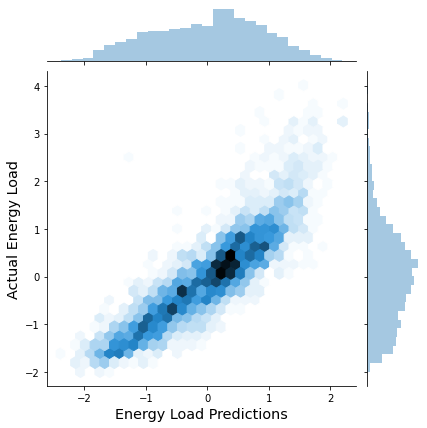

In [306]:
step = 50
grid = sn.jointplot(preds2.yhat[:-n_hours][::step], data_st.y[::step], alpha=0.2)
grid.set_axis_labels('Energy Load Predictions', 'Actual Energy Load', fontsize='x-large');
grid.savefig('joint_scatter2.png');

grid = sn.jointplot(preds2.yhat[:-n_hours][::step], data_st.y[::step], kind='hex')
grid.set_axis_labels('Energy Load Predictions', 'Actual Energy Load', fontsize='x-large');
grid.savefig('joint_hex2.png');

# Most complex model

Add separate daily seasonalities for the winter, summer, and spring/fall.



In [0]:
def is_winter(ds):
    date = pd.to_datetime(ds)
    if ((ds.month % 12 + 3) // 3) == 1: return 1
    else: return 0

def is_summer(ds):
    date = pd.to_datetime(ds)
    if ((ds.month % 12 + 3) // 3) == 3: return 1
    else: return 0

In [0]:
if False:
    data_seasons = data.copy()
    data_seasons["is_winter"] = data_seasons.ds.apply(is_winter)
    data_seasons["is_summer"] = data_seasons.ds.apply(is_summer)
    data_seasons['is_spring_fall'] = ~(data_seasons.is_winter | data_seasons.is_summer) + 2
    data_seasons.to_csv('data_seasons.csv')

    colx = ['y', 'weather_pc', 'precipitation']
    colkeep = ['ds', 'is_winter', 'is_summer', 'is_spring_fall']

    data_seasons_st = (data_seasons[colx] - data_seasons[colx].mean()) / data_seasons[colx].std()
    data_seasons_st[colkeep] = data_seasons[colkeep]
    data_seasons_st.to_csv('data_seasons_st.csv')

else:
    data_seasons = pd.read_csv('https://github.com/takao8/MLTSAProject/blob/master/data/data_seasons.csv?raw=true', index_col=0)
    data_seasons_st = pd.read_csv('https://github.com/takao8/MLTSAProject/blob/master/data/data_seasons_st.csv?raw=true', index_col=0)
    data_seasons.ds = pd.to_datetime(data_seasons.ds)
    data_seasons_st.ds = pd.to_datetime(data_seasons_st.ds)

In [0]:
# Create base instance of Prophet
prophet3 = Prophet(seasonality_prior_scale=35,
                 weekly_seasonality=False,)

# Add holidays
prophet3.add_country_holidays(country_name="US")

# Add seasonalities
prophet3.add_seasonality(name='daily_winter', period=7, fourier_order=10, condition_name='is_winter')
prophet3.add_seasonality(name='daily_summer', period=7, fourier_order=10, condition_name='is_summer')
prophet3.add_seasonality(name='daily_spring_fall', period=7, fourier_order=10, condition_name='is_spring_fall')
prophet3.add_seasonality(name='weekly', period=7, fourier_order=10)
prophet3.add_seasonality(name='quarterly', period=365/4, fourier_order=10)

# Add weather regressor
prophet3.add_regressor('weather_pc')
prophet3.add_regressor('precipitation')

# Fit model to data
if False:
    prophet3.fit(data_seasons_st)     # will take 13 minutes to run

    prophet3.stan_backend.logger = None
    with open("prophet3.pickle", "wb") as f:
        pickle.dump(prophet3, f)
else:
    prophet3_location = 'https://github.com/takao8/MLTSAProject/blob/master/trained_models/prophet3.pickle?raw=true'
    prophet3 = pickle.load(urlopen(prophet3_location))

In [0]:
if False:
    pred_period3 = pred_period2.copy()
    pred_period3["is_winter"] = pred_period3.ds.apply(is_winter)
    pred_period3["is_summer"] = pred_period3.ds.apply(is_summer)
    pred_period3['is_spring_fall'] = ~(pred_period3.is_winter | pred_period3.is_summer) + 2
    pred_period3.to_csv('pred_period3.csv')
else:
    pred_period3 = pd.read_csv('https://github.com/takao8/MLTSAProject/blob/master/data/prophet3/pred_period3.csv?raw=true', index_col=0)
    pred_period3['ds'] = pd.to_datetime(pred_period3.ds)

In [0]:
if True:
    # Forecast the energy load over the prediction perdiod dataframe
    preds3 = prophet3.predict(pred_period3)  # will take 2 minutes

    # Save the predictions in two separate files big the full dataset is larger than 100MB
    half = len(preds3) // 2
    preds3[:half].to_csv('preds3_1.csv')
    preds3[half:].to_csv('preds3_2.csv')
else:
    # Load the prediction data from GitHub
    preds3_1 = pd.read_csv('https://github.com/takao8/MLTSAProject/blob/master/data/prophet3/preds3_1.csv?raw=true', index_col=0)
    preds3_2 = pd.read_csv('https://github.com/takao8/MLTSAProject/blob/master/data/prophet3/preds3_2.csv?raw=true', index_col=0)
    preds3 = pd.concat([preds3_1, preds3_2])
    
    #preds3 = pd.read_csv('https://github.com/takao8/MLTSAProject/blob/master/data/prophet3/preds3.csv?raw=true', index_col=0)
    preds3['ds'] = pd.to_datetime(preds3.ds)

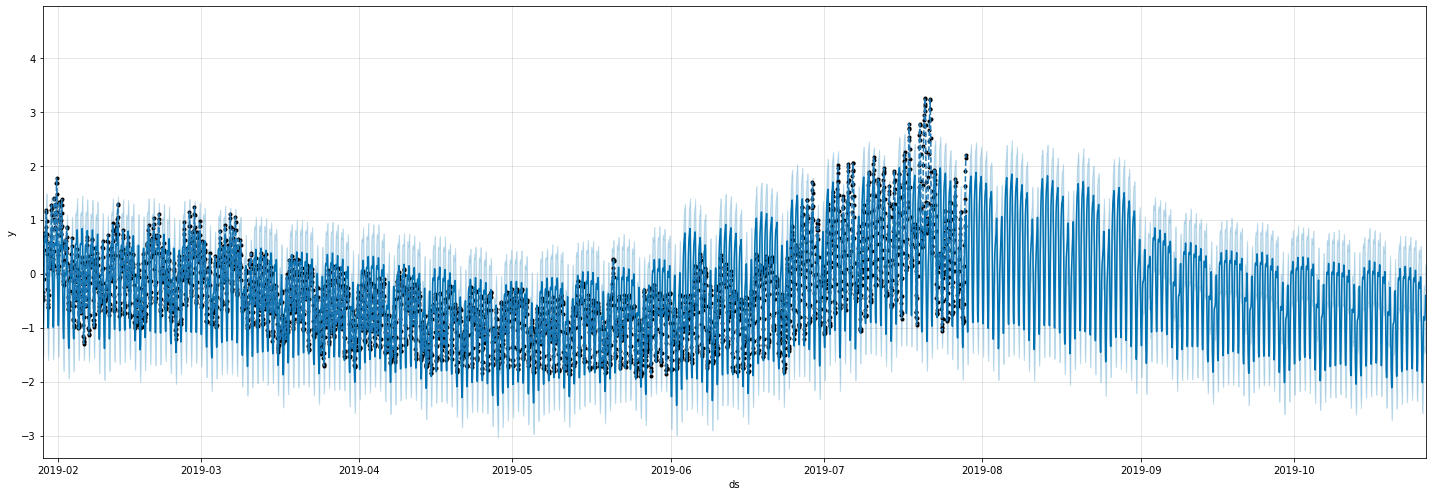

In [255]:
backtrack = n_hours * 2  # Show two 3-month periods

fig = prophet3.plot(preds3[-backtrack - n_hours:], figsize=(20, 7))
plt.plot(data_seasons_st.ds[-backtrack:], data_seasons_st.y[-backtrack:], '--')
plt.xlim(data_seasons_st.ds.values[-backtrack], preds3.ds.values[-1] + np.timedelta64(years=1))
fig.show();

fig.savefig('prophet3_predictions.png')

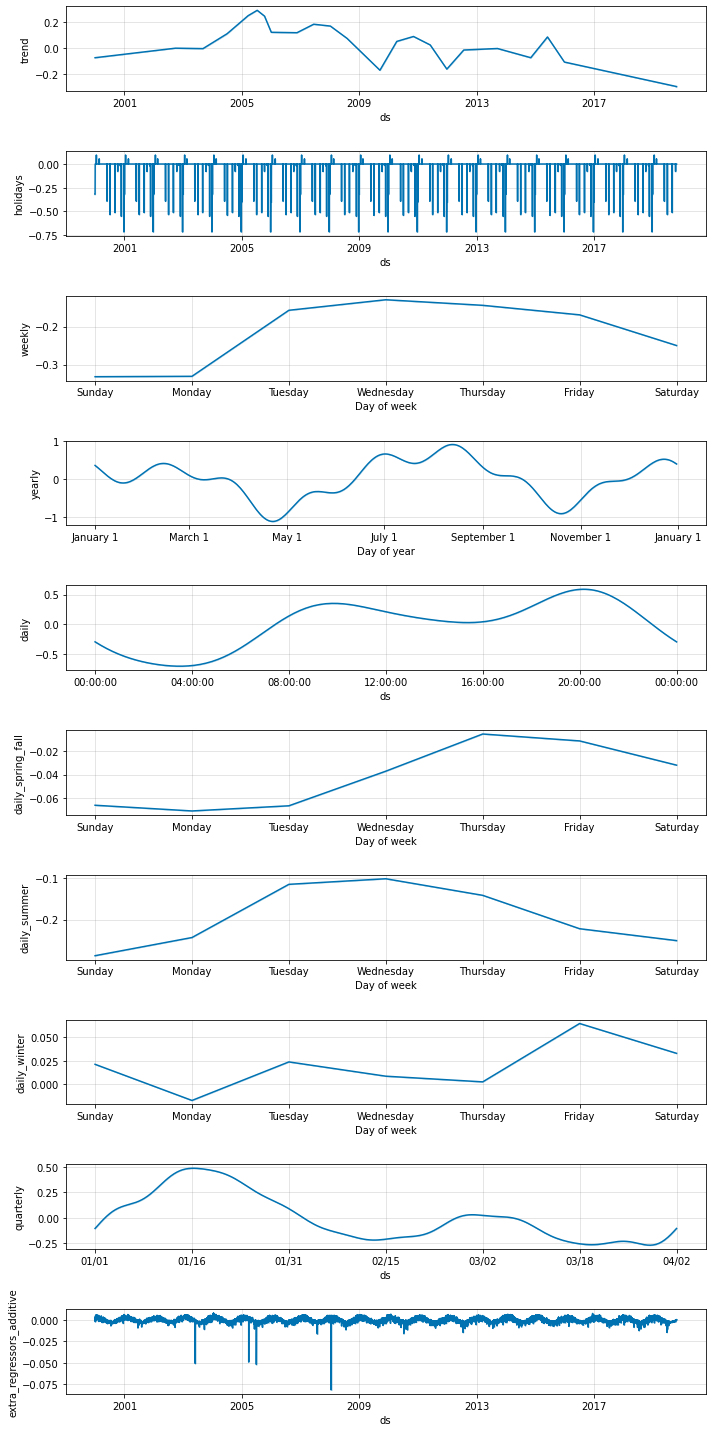

In [256]:
fig = prophet3.plot_components(preds3, figsize=(10, 20))
fig.savefig('prophet3_components.png')
fig.show();

In [0]:
if False:
    # Will take 37 minutes
    result3_cv = diagnostics.cross_validation(prophet3, initial="730 days", period="400 days",  horizon="90 days")
    result3_cv.to_csv('result3_cv.csv')

    # Unstandardize the results
    result3_cv_adj = result3_cv.copy()
    result3_cv_adj[['yhat', 'yhat_lower', 'yhat_upper', 'y']] *= data.y.std()
    result3_cv_adj[['yhat', 'yhat_lower', 'yhat_upper', 'y']] += data.y.mean()
    result3_cv_adj.to_csv('result3_cv_adj.csv')

else:
    # Load the cross-validation results from GitHub
    result3_cv = pd.read_csv('https://github.com/takao8/MLTSAProject/blob/master/data/prophet3/result3_cv.csv?raw=true', index_col=0)
    result3_cv_adj = pd.read_csv('https://github.com/takao8/MLTSAProject/blob/master/data/prophet3/result3_cv_adj.csv?raw=true', index_col=0)
    
    result3_cv['ds'] = pd.to_datetime(result3_cv.ds)
    result3_cv_adj['ds'] = pd.to_datetime(result3_cv_adj.ds)
    
    result3_cv['cutoff'] = pd.to_datetime(result3_cv.cutoff)
    result3_cv_adj['cutoff'] = pd.to_datetime(result3_cv_adj.cutoff)

In [258]:
print("Mean average percent error: {:.2%}".format(mape(result3_cv_adj.yhat, result3_cv_adj.y)))

Mean average percent error: 7.36%


In [0]:
if False:
    # Calculate the performance metrics on the cross-validation results
    result3_p = performance_metrics(result3_cv_adj)
    result3_p.to_csv('result3_p.csv')
else:
    # Load the performance metrics from GitHub
    result3_p = pd.read_csv('https://github.com/takao8/MLTSAProject/blob/master/data/prophet3/result3_p.csv?raw=true', index_col=0)
    result3_p['horizon'] = pd.to_timedelta(result3_p.horizon)

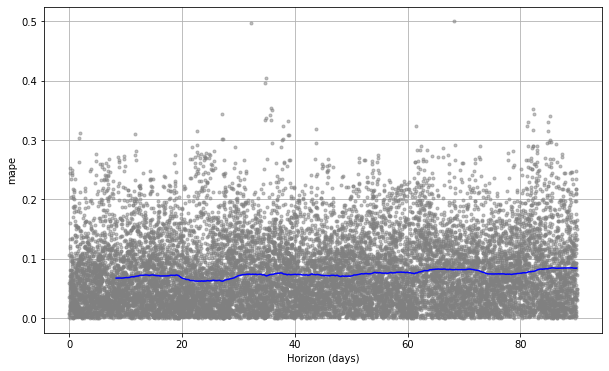

In [260]:
fig = plot_cross_validation_metric(result3_cv_adj[::2], metric='mape')
fig.savefig('prophet3_horizon_mape.png')

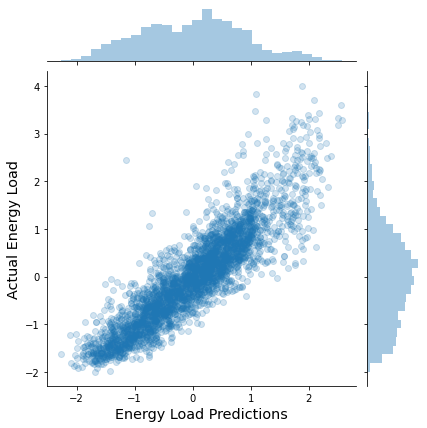

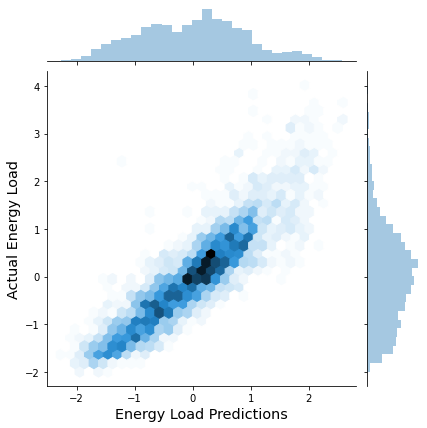

In [311]:
step = 50
grid = sn.jointplot(preds3.yhat[:-n_hours][::step], data_st.y[::step], alpha=0.2)
grid.set_axis_labels('Energy Load Predictions', 'Actual Energy Load', fontsize='x-large');
grid.savefig('joint_scatter3.png');

grid = sn.jointplot(preds3.yhat[:-n_hours][::step], data_st.y[::step], kind='hex')
grid.set_axis_labels('Energy Load Predictions', 'Actual Energy Load', fontsize='x-large');
grid.savefig('joint_hex3.png');